****************Logistic Classification****************

              Head value:
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease
0   40   M           ATA        140          289          0     Normal    172              N      0.0       Up             0
1   49   F           NAP        160          180          0     Normal    156              N      1.0     Flat             1
2   37   M           ATA        130          283          0         ST     98              N      0.0       Up             0
3   48   F           ASY        138          214          0     Normal    108              Y      1.5     Flat             1
4   54   M           NAP        150          195          0     Normal    122              N      0.0       Up             0

              Describe:
              Age   RestingBP  Cholesterol   FastingBS       MaxHR     Oldpeak  HeartDisease
count  918.000000  918.000000   918.000000  918.0

Would you like to see the visuals (Yes/No):  Yes


Displaying visuals...


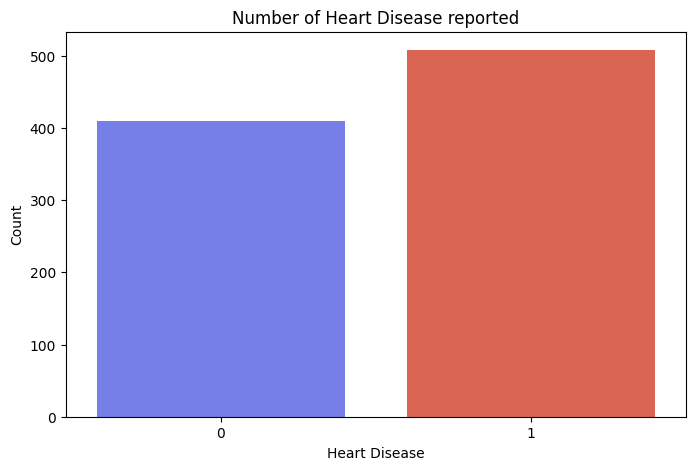

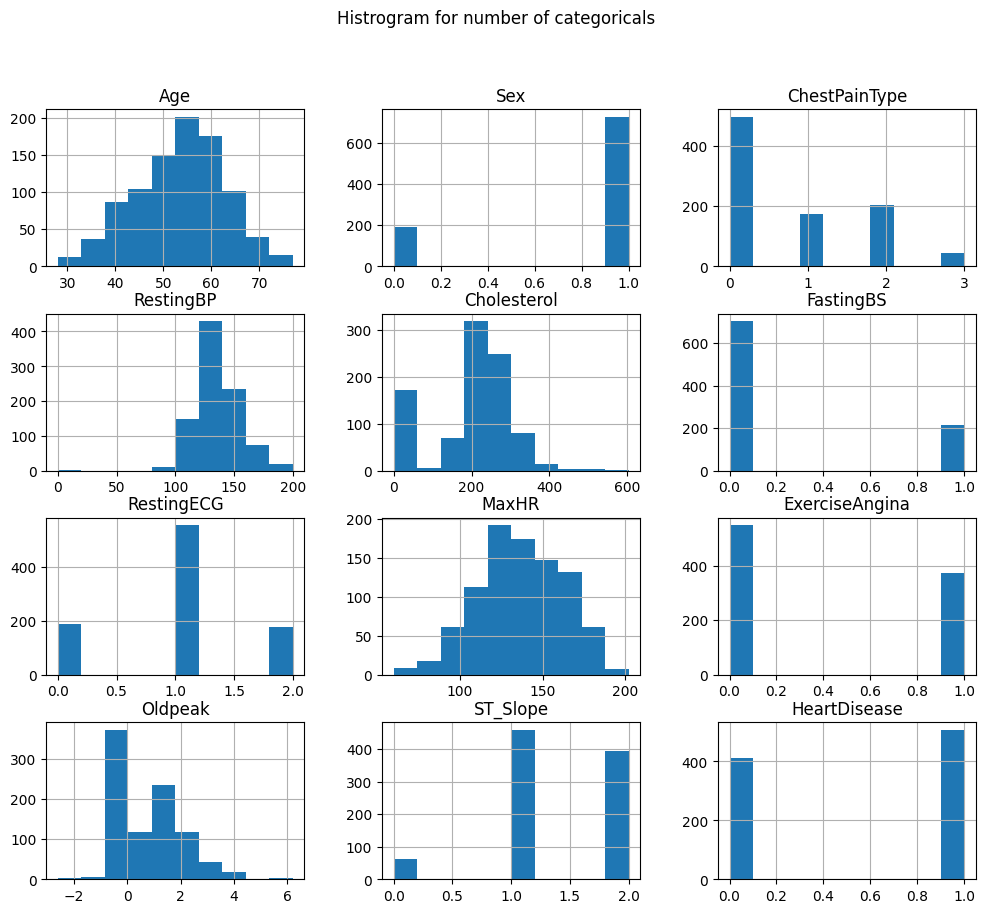

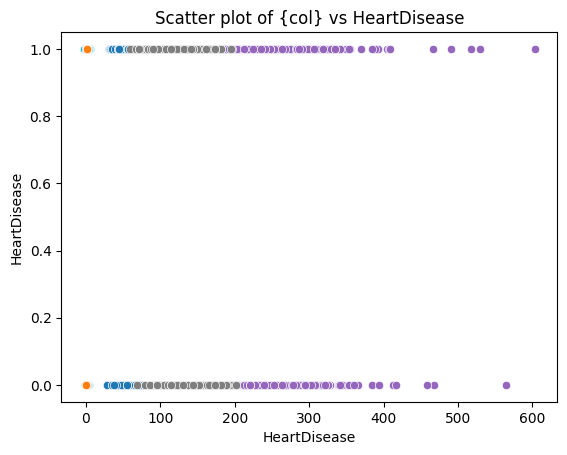

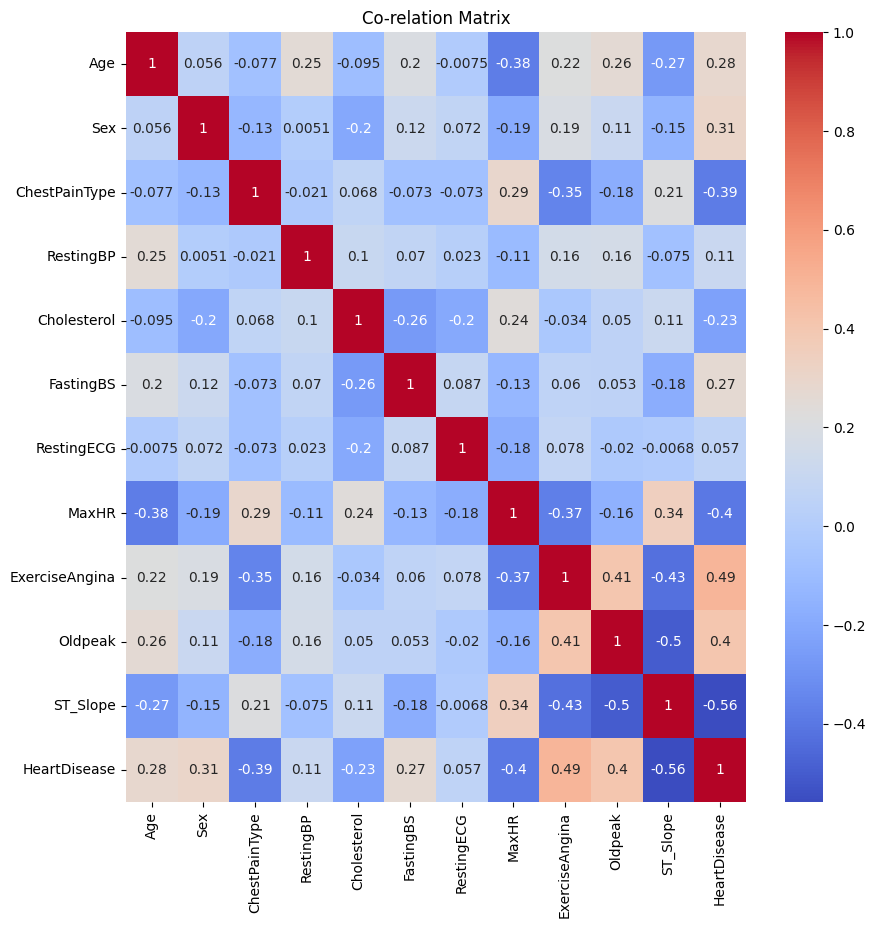


ROC-AUC Score: 1.0


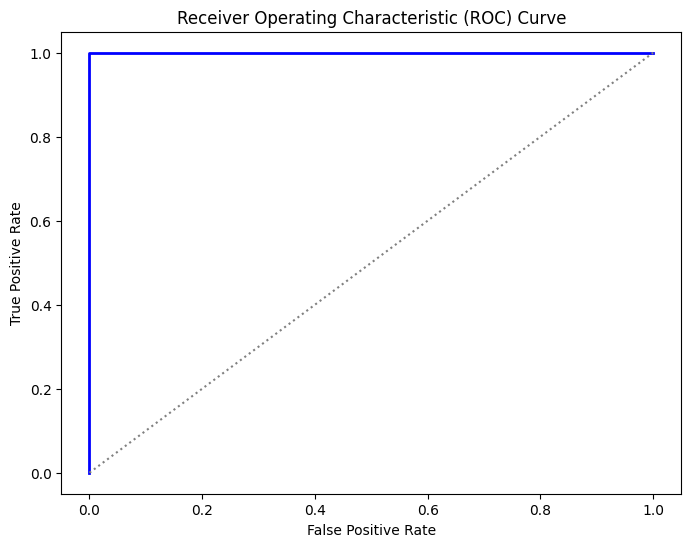

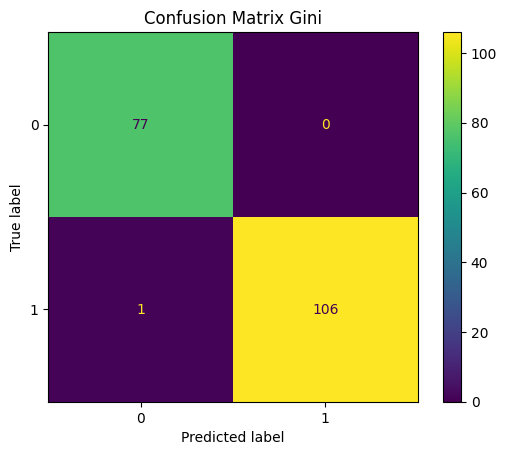

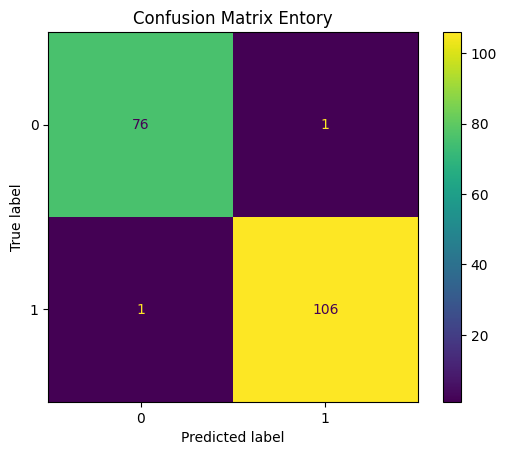

Have Heart Disease: 508
Do Not Have Heart Disease: 410
Thresholds [       inf 0.99861836 0.96116424 0.00159858]


Age :  50
Sex (M/F) :  M
ChestPainType (ASY/ATA/NAP/TA) :  TA
Cholesterol :  65
FastingBS (0/1) :  1
MaxHR :  61
ExerciseAngina (Y/N) :  Y
Oldpeak :  65
ST_Slope (Down/Flat/Up) :  Up


   Age Sex ChestPainType  Cholesterol  FastingBS  MaxHR ExerciseAngina  Oldpeak ST_Slope
0   50   M            TA           65          1     61              Y       65       Up


ValueError: columns are missing: {'RestingBP', 'RestingECG', 'HeartDisease'}

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 10000)

class LogisticModel:
    def __init__(self):
        self.df = pd.read_csv(r'C:\Users\jayavaradhan.olivu\OneDrive - DISYS\Documents\Data Science\Data-Science\Data Science\Projects\heart.csv')
        self.Target = self.df['HeartDisease']
        self.LE = LabelEncoder()
        self.LOG_Model = LogisticRegression()
        self.RFC_Gini_Model = RandomForestClassifier(n_estimators=5, criterion='gini', random_state=100)
        self.RFC_Entory_Model = RandomForestClassifier(n_estimators=5, criterion='entropy', random_state=100)
        
    def import_data(self):
    
        df_copy = self.df.copy()
        head_value = df_copy.head()
        describe = df_copy.describe()
        null_val = df_copy.isna().sum()
        print(f'''
              Head value:\n{head_value}\n
              Describe:\n{describe}\n
              Null Val:\n{null_val}\n
              ''')
        return df_copy

    def preprocessing(self, df_copy):

        cat_features = [col for col in df_copy.columns if df_copy[col].dtype == 'object']
        for col in cat_features:
            df_copy[col] = self.LE.fit_transform(df_copy[col])
        print(df_copy.head())
        return df_copy  # Return the preprocessed DataFrame

    def feature_selection(self, df_copy):
        print('\n Feature selection...')
        corr_matrix = df_copy.corr(method='pearson')
        thresh_hold = 0.2
        selected_features = corr_matrix.index[abs(corr_matrix['HeartDisease']) >= thresh_hold].to_list()
        selected_features.remove('HeartDisease')
        selected_features_df = df_copy[selected_features]  # Use df_copy instead of self.df
        print(selected_features_df.head())
        return selected_features_df

    def create_pipeline(self, selected_features):

        print('\n Creating pipeline...')
        
        cat_features = [col for col in self.df.columns if self.df[col].dtype == 'object']
        num_features = [col for col in self.df.columns if self.df[col].dtype != 'object']
        
        print(f'''
            Categorical Features:
                {cat_features}\n
            Numerical Features: 
                {num_features}\n
        ''')

        num_transfer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        cat_transfer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        col_transfer = ColumnTransformer(transformers=[
            ('num', num_transfer, num_features),
            ('cat', cat_transfer, cat_features)
            ],
            remainder='passthrough').set_output(transform='pandas')

        # print(col_transfer.fit_transform(self.df))
        
        x_train, x_test, y_train, y_test = train_test_split(self.df, self.Target, test_size=0.2, random_state=42)

        print("Shape of selected_features:", selected_features.shape)
        print("Shape of Target:", self.Target.shape)
        print("Shapes after split:")
        print("x_train:", x_train.shape)
        print("x_test:", x_test.shape)
        print("y_train:", y_train.shape)
        print("y_test:", y_test.shape)

        return col_transfer, x_train, y_train, x_test, y_test

    def train_and_predict(self, x_train, y_train, x_test, col_transfer):
        print('\n Training and predicting using Logistic Regression...')
        LOG_pipeline = make_pipeline(col_transfer, self.LOG_Model)
        LOG_pipeline.fit(x_train, y_train)
        
        LOG_y_pred = LOG_pipeline.predict(x_test)
        LOG_y_prob = LOG_pipeline.predict_proba(x_test)[:, 1]
        
        return LOG_y_pred, LOG_y_prob, LOG_pipeline

    def evaluate_model(self, x_train, y_train, x_test, y_test, LOG_y_pred, LOG_pipeline):
        print('\n Evaluating model...')
        train_score = LOG_pipeline.score(x_train, y_train)
        test_score = LOG_pipeline.score(x_test, y_test)
        conf_matrix = confusion_matrix(y_test, LOG_y_pred)
        class_report = classification_report(y_test, LOG_y_pred)
        acc_score = accuracy_score(y_test, LOG_y_pred)

        print(f'''\n 
        Train Score: {(train_score * 100)} % \n
        Test Score: {(test_score * 100)} % \n
        Accuracy Score: {(acc_score * 100)} % \n
        Confusion Matrix:
        {conf_matrix} \n
        Classification Report:
        {class_report}  \n      
        ''')
        
class Random_Forest(LogisticModel):
    
    def train_using_gini(self, col_transfer, x_train, y_train, x_test):
        
        RFC_Gini_pipeline = make_pipeline(col_transfer, self.RFC_Gini_Model)
        RFC_Gini_pipeline.fit(x_train, y_train)
        RFC_y_pred_Gini = RFC_Gini_pipeline.predict(x_test)

        return RFC_y_pred_Gini, RFC_Gini_pipeline
    
    def metric_gini(self, RFC_y_pred_Gini, RFC_Gini_pipeline, x_train, y_train, y_test, x_test):
        
        RFC_train_score_gini = RFC_Gini_pipeline.score(x_train, y_train)
        RFC_test_score_gini = RFC_Gini_pipeline.score(x_test, y_test)
        RFC_accouracy_gini = accuracy_score(y_test, y_pred=RFC_y_pred_Gini)
        RFC_confusion_matrix_gini = confusion_matrix(y_test, RFC_y_pred_Gini)
        RFC_classification_report_gini = classification_report(y_test, RFC_y_pred_Gini)
        print(f'''\n Gini Metrics \n
        Train Score: {(RFC_train_score_gini * 100)} % \n
        Test Score: {(RFC_test_score_gini * 100)} % \n
        Accuracy Score: {(RFC_accouracy_gini * 100)} % \n
        Confusion Matrix:
        {RFC_confusion_matrix_gini} \n
        Classification Report:
        {RFC_classification_report_gini}        
        ''')
        
        return RFC_confusion_matrix_gini
        
    def train_using_entory(self, col_transfer, x_train, y_train, x_test):
        
        RFC_Entory_pipeline = make_pipeline(col_transfer, self.RFC_Entory_Model)
        RFC_Entory_pipeline.fit(x_train, y_train)
        RFC_y_pred_Entory = RFC_Entory_pipeline.predict(x_test)
        
        return RFC_y_pred_Entory, RFC_Entory_pipeline

    def metric_entory(self, RFC_y_pred_Entory, RFC_Entory_pipeline, x_train, y_train, y_test, x_test):
               
        RFC_train_score_entory = RFC_Entory_pipeline.score(x_train, y_train)
        RFC_test_score_entory = RFC_Entory_pipeline.score(x_test, y_test)
        RFC_accouracy_entory = accuracy_score(y_test, y_pred=RFC_y_pred_Entory)
        RFC_confusion_matrix_entory = confusion_matrix(y_test, RFC_y_pred_Entory)
        RFC_classification_report_entory = classification_report(y_test, RFC_y_pred_Entory)
        print(f''' Entory Metrics \n
        Train Score: {(RFC_train_score_entory * 100)} % \n
        Test Score: {(RFC_test_score_entory * 100)} % \n
        Accuracy Score: {(RFC_accouracy_entory * 100)} % \n
        Confusion Matrix:
        {RFC_confusion_matrix_entory} \n
        Classification Report:
        {RFC_classification_report_entory}        
        ''')
        
        return RFC_confusion_matrix_entory
    
    def Cross_validation(self, RFC_Entory_pipeline, RFC_Gini_pipeline, x_train, y_train):
        
        cross_validation_gini = cross_val_score(estimator=RFC_Gini_pipeline, X=x_train, y=y_train, cv=10)
        cross_validation_entropy = cross_val_score(estimator=RFC_Entory_pipeline, X=x_train, y=y_train, cv=10)
        
        print(f''' Cross-Validation:
              Gini:
              {cross_validation_gini}\n 
              Entory:
              {cross_validation_entropy}\n''') 

class visuals(Random_Forest):
    
    def visualize_data(self, df_copy, y_test, LOG_y_prob, RFC_confusion_matrix_gini, RFC_confusion_matrix_entory):
        custom_palette = ['#636EFA', '#EF553B']
        
        plt.figure(figsize=(8, 5))
        sns.countplot(data=df_copy, x='HeartDisease', palette=custom_palette)
        plt.title('Number of Heart Disease reported')
        plt.xlabel('Heart Disease')
        plt.ylabel('Count')
        plt.show()
        
        df_copy.hist(figsize=(12,10))
        plt.suptitle('Histrogram for number of categoricals')   
        plt.show()
        for col in df_copy.columns:
            sns.scatterplot(x=df_copy[col], y=df_copy['HeartDisease'],legend=True)
            plt.title('Scatter plot of {col} vs HeartDisease')
            plt.xlabel(col)
            plt.ylabel('HeartDisease') 
        plt.show()
            
        corr_matrix = df_copy.corr(method='pearson')
        plt.figure(figsize=(10, 10))
        plt.title('Co-relation Matrix')
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
        plt.show()
        
        roc_auc = roc_auc_score(y_test, LOG_y_prob)
        print("\nROC-AUC Score:", roc_auc)

        ''' 
        fpr (False Positive Rate)
        tpr (True positive Rate)
        '''

        fpr, tpr, thresholds = roc_curve(y_test, LOG_y_prob)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='gray', linestyle='dotted')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.show()
        
        plt_confusion_gini = ConfusionMatrixDisplay(confusion_matrix=RFC_confusion_matrix_gini)
        plt_confusion_gini.plot()
        plt.title('Confusion Matrix Gini')
        plt.show()

        plt_confusion_entory = ConfusionMatrixDisplay(confusion_matrix=RFC_confusion_matrix_entory)
        plt_confusion_entory.plot()
        plt.title('Confusion Matrix Entory')
        plt.show()
        
        Yes, No = df_copy['HeartDisease'].value_counts()
        
        print('Have Heart Disease:', Yes)
        print('Do Not Have Heart Disease:', No)
        print('Thresholds', thresholds)

class user_friendly_interface(visuals):
    
    def info(self, LOG_pipeline, col_transfer):
        
        Age = int(input('Age : '))
        Sex = str(input('Sex (M/F) : '))
        ChestPainType = str(input('ChestPainType (ASY/ATA/NAP/TA) : '))
        Cholesterol = int(input('Cholesterol : '))
        FastingBS = int(input('FastingBS (0/1) : '))
        MaxHR = int(input('MaxHR : '))
        ExerciseAngina = str(input('ExerciseAngina (Y/N) : '))
        Oldpeak = int(input('Oldpeak : '))
        ST_Slope = str(input('ST_Slope (Down/Flat/Up) : '))
    
        values = {'Age': [Age], 'Sex': [Sex], 'ChestPainType': [ChestPainType], 
          'Cholesterol': [Cholesterol], 'FastingBS': [FastingBS], 'MaxHR': [MaxHR],
          'ExerciseAngina': [ExerciseAngina], 'Oldpeak': [Oldpeak], 'ST_Slope': [ST_Slope]}
        
        user_df = pd.DataFrame(data=values)
        
        print(user_df)
        
        LOG_pipeline = make_pipeline(col_transfer, self.LOG_Model)
        
        LOG_predication = LOG_pipeline.predict(user_df)
        
        print(LOG_predication)
    
    
def main():

    print('****************Logistic Classification****************')
    
    model1 = LogisticModel()
    
    data = model1.import_data()
    data = model1.preprocessing(data)  # Update data with the preprocessed DataFrame
    
    selected_features = model1.feature_selection(data)
    col_transfer, x_train, y_train, x_test, y_test = model1.create_pipeline(selected_features)
    
    LOG_y_pred, LOG_y_prob, LOG_pipeline = model1.train_and_predict(x_train, y_train, x_test, col_transfer)
    model1.evaluate_model(x_train, y_train, x_test, y_test, LOG_y_pred, LOG_pipeline)
    
    print('\n ****************Random Forest Classification****************')
    
    model2 = Random_Forest()
    
    RFC_y_pred_Gini, RFC_Gini_pipeline = model2.train_using_gini(col_transfer, x_train, y_train, x_test)
    RFC_confusion_matrix_gini = model2.metric_gini(RFC_y_pred_Gini, RFC_Gini_pipeline, x_train, y_train, y_test, x_test)
    RFC_y_pred_Entory, RFC_Entory_pipeline = model2.train_using_entory(col_transfer, x_train, y_train, x_test)
    RFC_confusion_matrix_entory = model2.metric_entory(RFC_y_pred_Entory, RFC_Entory_pipeline, x_train, y_train, y_test, x_test)
    model2.Cross_validation(RFC_Entory_pipeline, RFC_Gini_pipeline, x_train, y_train)  

    print('\n************************Visualization************************')
    
    visual = visuals()
    
    value = str(input('Would you like to see the visuals (Yes/No): ')).strip().capitalize()
    
    if value == 'Yes':

        print('Displaying visuals...')
        visual.visualize_data(data, y_test, LOG_y_prob, RFC_confusion_matrix_gini, RFC_confusion_matrix_entory)
    
    elif value == 'No':
    
        print('Skipping visuals...')
    
    else:
        print('Invalid input, please enter Yes or No.')
        main()
    
    us = user_friendly_interface()
    us.info(LOG_pipeline, col_transfer)

        

if __name__ == '__main__':
    main()
